#### Aim of this notebook is a simple to provide a first visualization of the official corona cases in each Bundesland

In [128]:
import pandas as pd
import numpy as np
import statsmodels
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from typing import List, Tuple

%matplotlib inline

Parameters

In [2]:
ger_population = 8.2*10e7
dates = pd.date_range('2020-01-27', '2020-12-31')  #data range for the whole year starting from the first point for which we have german data

In [45]:
df = pd.read_csv('../../data/Coronavirus.history.v2.csv')
df_einwohner = pd.read_csv('../../data/einwohner_bundeslaender.csv', sep='\t')
einwohner_dict = df_einwohner.set_index('Bundesland').to_dict()['Einwohner']
df_filtered = df[df['parent'] == 'Deutschland']

df_filtered.head()

,parent,label,date,lon,lat,confirmed,recovered,deaths
23,Deutschland,Bayern,2020-01-27,11.658165,48.768814,1,0,0
78,Deutschland,Bayern,2020-01-28,11.658165,48.768814,4,0,0
140,Deutschland,Bayern,2020-01-29,11.658165,48.768814,4,0,0
201,Deutschland,Bayern,2020-01-30,11.658165,48.768814,5,0,0
244,Deutschland,Bayern,2020-01-31,11.658165,48.768814,7,0,0


pivot so that table is in wide format

In [4]:
df_pivot = pd.pivot_table(df_filtered, index='date', columns='label', values='confirmed').fillna(0)

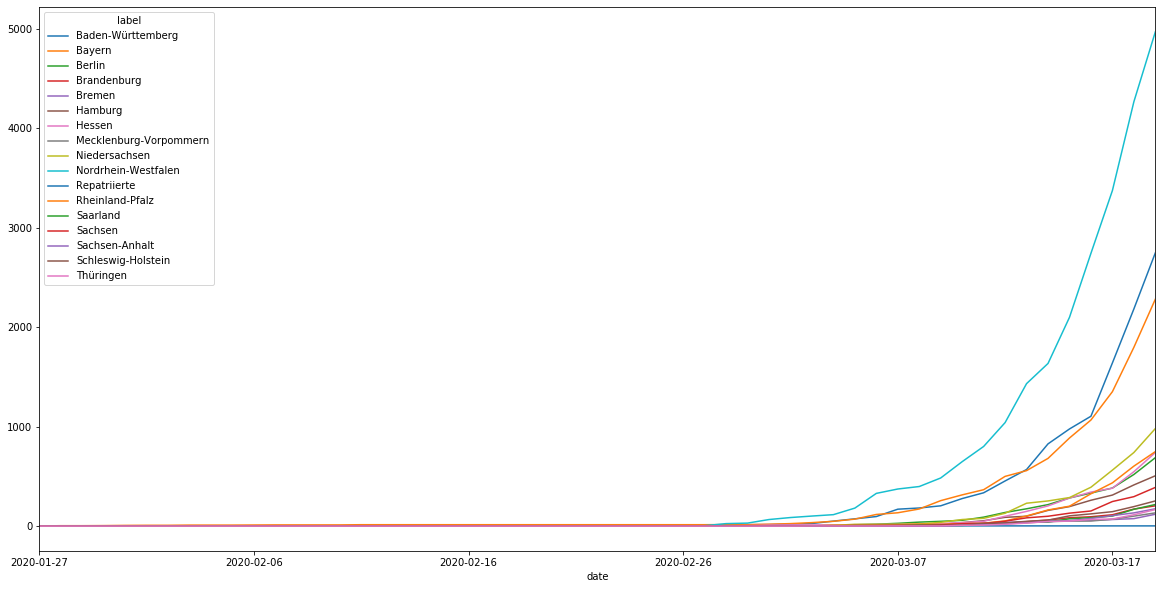

In [5]:
df_pivot.plot(figsize=(20, 10))

Number of data points

In [6]:
len(df_pivot.index)

53

The function we are looking for increases exponentially at the beginning but saturates as larger parts of the population is already infected or already recovered from the disease. A first approach is a (in x-direction) shifted sigmoid function: <br/>
<br/>

$f_{ansatz}(x, \beta, x_{0}) = \frac{N}{1+e^{\beta (x-x_{0})}}$
<br/>

The idea is to find the parameters $\beta$ and $x_{0}$ from the data. While $\beta$ describes the growth rate $x_{0}$ is the timely delay, the number of days after which the disease broke out. The parameter $N$ the total infections. Therefore it is constant and in case of a total (Durchseuchung) we use the population times and infection rate. In general these parameters (except $N$) can take multidimensional forms.

Before we handle the multidimensional case let's take a first example in how to fit the data for Baden-Württemberg.

In [118]:
len(dates)

340

In [127]:
def fit_sigmoid(bd_land: str, days: int) -> Tuple[np.array, List[str], np.array]:
    """ fit a sigmoid function to the Bundesländer. We create a local function sigmoid which will be fitted by
    scipy. 
    :param bd_land: Bundesland of Germany
    :param days: any number of days between 0 and 340 (number of days till the year ends starting from 2020-01-27
    which is the first time we have data)
    :returns opt_param: optimal params (list)"""
    inf_rate = 0.7  #Durchseuchungsrate
    pop = einwohner_dict[bd_land]
    def sigmoid(x, beta, x0):
        return inf_rate*pop/(1+np.exp(-np.dot(beta, (x-x0))))
    opt_param, _ = curve_fit(sigmoid, range(len(df_pivot.index)), df_pivot[bd_land], p0=np.array([0.2, 25]))
    #prediction function using optimal parameters
    f = lambda x: sigmoid(x, *opt_param)
    return opt_param, dates[:days], f(np.array(range(days)))

opt_param, x, y = fit_sigmoid('Baden-Württemberg', 55)

In [119]:
opt_param

array([ 0.26100307, 82.35959176])

We provide a function with which we can easily play and do a very basic forecasting

In [138]:
def show_n_days(bundesland: str, days: int) -> None:
    _, x, y = fit_sigmoid(bundesland, days)
    plt.plot(dates[:len(df_pivot.index)], df_pivot[bundesland], 'o', label='actual data')
    plt.plot(x, y, label='sigmoid prediction')
    plt.legend()
    plt.xticks(rotation=90)

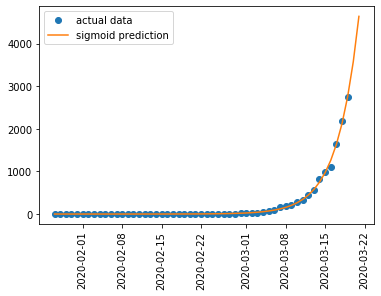

In [137]:
show_n_days('Baden-Württemberg', 55)

In [87]:
#TODO: write function which returns total cases as number for a given date

This seems pretty reasonable

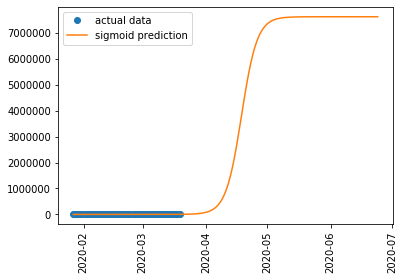

In [132]:
show_n_days('Baden-Württemberg', 150)

### Tough things are ahead of us if no measures are taken

Now let us compute the values for each Bundesland

In [94]:
result_df = pd.DataFrame(columns=['Bundesland','beta','x0'])
for bd_land in df_pivot.columns:
    if bd_land not in einwohner_dict:  #There is one strange bundesland called 'Repatriierte'
        continue
    opt_param, _, _ = fit_sigmoid(bd_land, days=100)
    result_df = result_df.append({'Bundesland': bd_land, 'beta': opt_param[0], 'x0': opt_param[1]}, ignore_index=True)

In [114]:
result_df['date_x0'] = result_df['x0'].apply(lambda x: dates[int(x)])
result_df

,Bundesland,beta,x0,date_x0
0,Baden-Württemberg,0.261003,82.359592,2020-04-18
1,Bayern,0.233541,87.508177,2020-04-23
2,Berlin,0.244244,85.567256,2020-04-21
3,Brandenburg,0.267856,85.677582,2020-04-21
4,Bremen,0.194801,94.952561,2020-04-30
5,Hamburg,0.261414,81.749879,2020-04-17
6,Hessen,0.279011,83.112192,2020-04-19
7,Mecklenburg-Vorpommern,0.253234,87.856229,2020-04-23
8,Niedersachsen,0.289924,81.789710,2020-04-17
9,Nordrhein-Westfalen,0.223258,86.910765,2020-04-22


How to interpret this data: <br/>
 - larger $\beta$ means a faster saturation is reached. The speed of infections is higher compared to lower $\beta$s
 - the shift $x0$ means day (corresponding date can be found in date_x0 column) when the number of infections reaches half of its global maximum.